# 1 Abstract

Autoencoders are an unsupervised learning technique in which we leverage neural networks for the task of representation learning. <br>

Autoencoder has two parts. <br>
1) Encoder <br>
It learns lower dimension data representation. <br>
2) Decoder <br>
Reconstruct original data from learned lower dimension from encoder layer. <br>
$x$ --- Encoder layer --- $z$ --- Decoder Layer --- $\hat{x}$

$z = f(h_e(x))$ <br>
$z$ is learned lower dimension data representation from input data $x$ <br>

$\hat{x} = f(h_d(z))$ <br>
$\hat{x}$ is reconstructed data based on learned representation $z$ <br>

Here, model is trained to use features from the input ($x$) to learn the latent space ($z$) to reconstruct the input ($x$) it self.

Here the Reconstruction Loss function is mean-squared-error, <br>
$\mathcal{L}(x, \hat{x}) = 
\frac{1}{N}\sum_{i=1}^{N}
{\lVert (x_i - \hat{x_i})\rVert}^2$

# 2 Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
g_path = "/content/drive/My Drive/ml-data/"
curr_path = "/content/drive/My Drive/pytorch-nlp/Generative_Model/AutoEncoder/"

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import pickle
from sklearn.manifold import TSNE
from IPython.display import Image
import copy
import torch
from torch import nn
import torch.optim as optim
from typing import OrderedDict
from datetime import datetime
from torch.utils.data import Dataset, DataLoader
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib import animation

# 3 Defining configuration and constants/parameters

In [ ]:
'''
specifying the config information
'''
def gen_conf():
  conf = {
      "rand_seed": 123,
      "device": "",
      "lr_rate": 0.00001,
      "epochs": 1000,
      "show_epoch_info": 100, 
      "vocab_len": -1,
      "word_dim": 300,
      "embed_dict_fl": 'concap_embed_dict_fast.pkl',
      "load_pretrained": True,
      "data":{
          "train_data_fl": 'data/concap_modf.csv',
          "train_batch_size": 5
      },
      "model_path": "/model/ae.pth"
  }

  return conf

# 4 Data

In [ ]:
def get_data(data_fl):
  concap = pd.read_csv(g_path+data_fl, header=0)
  return concap

In [ ]:
def load_pre_vec(vec_dict_fl):
  # 'concap_embed_dict_fast.pkl'
  # 'concap_embed_dict_bert.pkl'
  with open(g_path+'data/'+vec_dict_fl, 'rb') as f:
    concap_embed_dict = pickle.load(f)

  return concap_embed_dict

# 4.1 Vocabulary

In [ ]:
class Vocabulary:

  '''
    __init__ method is called by default as soon as an object of this class is initiated
    we use this method to initiate our vocab dictionaries
  '''
  def __init__(self, conf, freq_threshold=0, max_size=0):
    '''
      ## <PAD> -> padding, used for padding the shorter sentences in a batch to match the length of longest sentence in the batch
      ## <SOS> -> start token, added in front of each sentence to signify the start of sentence
      ## <EOS> -> End of sentence token, added to the end of each sentence to signify the end of sentence
      ## <UNK> -> words which are not found in the vocab are replace by this token
    '''
    self.itos = {0: '<PAD>', 1: '<SOS>', 2: '<EOS>', 3: '<UNK>'}
    # initiate token to index dict
    self.stoi = {k:j for j,k in self.itos.items()}
    self.idx_to_vec = {
       0: np.zeros(conf['word_dim']), 
       1: np.zeros(conf['word_dim']),
       2: np.zeros(conf['word_dim']),
       3: np.zeros(conf['word_dim'])
    }

    self.freq_threshold = freq_threshold
    self.max_size = max_size

  '''
  __len__ is used by dataloader later to create batches
  '''
  def __len__(self):
      return len(self.itos)

  '''
  a simple tokenizer to split on space and converts the sentence to list of words
  '''
  @staticmethod
  def tokenizer(text):
      return [tok.lower().strip() for tok in text.split(' ')]

  '''
  build the vocab: create a dictionary mapping of index to string (itos) and string to index (stoi)
  output ex. for stoi -> {'the':5, 'a':6, 'an':7}
  '''
  def build_vocabulary(self, concap_embed_dict):
      
      # #calculate the frequencies of each word first to remove the words with freq < freq_threshold
      # frequencies = {}  #init the freq dict
      # idx = 4 #index from which we want our dict to start. We already used 4 indexes for pad, start, end, unk
      
      # #calculate freq of words
      # for sentence in sentence_list:
      #     for word in self.tokenizer(sentence):
      #         if word not in frequencies.keys():
      #             frequencies[word]=1
      #         else:
      #             frequencies[word]+=1
                  
                  
      # #limit vocab by removing low freq words
      # frequencies = {k:v for k,v in frequencies.items() if v>self.freq_threshold} 
      
      # #limit vocab to the max_size specified
      # frequencies = dict(sorted(frequencies.items(), key = lambda x: -x[1])[:self.max_size-idx]) # idx =4 for pad, start, end , unk
          
      # #create vocab
      # for word in frequencies.keys():
      #     self.stoi[word] = idx
      #     self.itos[idx] = word
      #     idx+=1

      idx = 4 #index from which we want our dict to start. We already used 4 indexes for pad, start, end, unk
      stop_words = ['', 'nan']
      for word in concap_embed_dict:
        word = word.lower().strip()
        if word not in self.stoi and word not in stop_words:
          self.stoi[word] = idx
          self.itos[idx] = word
          self.idx_to_vec[idx] = concap_embed_dict[word]
          idx+=1
        else:
          print("word excluded :- ", word)

      return


  '''
  convert the list of words to a list of corresponding indexes
  '''    
  def numericalize_txt(self, text):
      # #tokenize text
      # tokenized_text = self.tokenizer(text)
      # numericalized_text = []
      # for token in tokenized_text:
      #     if token in self.stoi.keys():
      #         numericalized_text.append(self.stoi[token])
      #     else: #out-of-vocab words are represented by UNK token index
      #         numericalized_text.append(self.stoi['<UNK>'])

      numericalized_text = []
      if text in self.stoi.keys():
        numericalized_text.append(self.stoi[text])
      else: #out-of-vocab words are represented by UNK token index
        numericalized_text.append(self.stoi['<UNK>'])
              
      return numericalized_text

  '''
  convert the list of words to a list of corresponding vectors
  '''
  def vectorize_txt(self, text):

    vectorize_text = []
    if text in self.stoi.keys():
      txt_idx = self.stoi[text]
    else: #out-of-vocab words are represented by UNK token index
     txt_idx = self.stoi['<UNK>']

    vectorize_text.append(self.idx_to_vec[txt_idx])     
    return vectorize_text



# 4.2 Generate Dataset

In [ ]:
class CustomAEDataset(Dataset):

  def __init__(self, df, conf, concap_embed_dict, **kwargs):
    
    # concatenating df1 and df2 along rows
    vertical_concat = pd.concat([df['CountryName'], df['CapitalName']], axis=0)
    vertical_concat = vertical_concat.to_frame(name='word')
    vertical_concat = vertical_concat[vertical_concat['word'].notna()]
    
    self.df = vertical_concat
    self.vocab = Vocabulary(conf)
    self.vocab.build_vocabulary(concap_embed_dict)

    return

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    txt = self.df.iloc[idx].values[0]
    txt_tensor = torch.tensor(self.vocab.numericalize_txt(txt))
    txt_vec_tensor = torch.FloatTensor(self.vocab.vectorize_txt(txt))
    return txt_tensor, txt_vec_tensor
  
  @classmethod
  def get_loder(self, data_set, conf, ind):
    if ind == 'train':
      data_loader = DataLoader(data_set, 
                               batch_size=conf['data']['train_batch_size'], 
                               shuffle=False)
    if ind == 'validation':
      data_loader = DataLoader(data_set, 
                               batch_size=conf['data']['valid_batch_size'], 
                               shuffle=False)
    if ind == 'test':
      data_loader = DataLoader(data_set, 
                               batch_size=conf['data']['test_batch_size'], 
                               shuffle=False)

    return data_loader

  '''
  returning the pre-trained vectors
  '''
  def get_pretrained_vec(self):
    return torch.FloatTensor(list(self.vocab.idx_to_vec.values()))

# 5 Auto Encoder model

In [ ]:
class Encoder(nn.Module):

  def __init__(self, config, pretrained_embeddings):
    super(Encoder, self).__init__()

    self.encoder_layer = nn.Sequential(
        OrderedDict([
            ('1_EMBED', nn.Embedding(num_embeddings=config['vocab_len'], embedding_dim=300, padding_idx=1, device=config['device'])),
            ('2_LINEAR', nn.Linear(in_features=300, out_features=200, device=config['device'])),
            ('3_LINEAR', nn.Linear(in_features=200, out_features=100, device=config['device']))
        ])
    )

    if config['load_pretrained']:
      self.encoder_layer._modules['1_EMBED'].weight.data.copy_(pretrained_embeddings)

  def forward(self, x):

    embed_layer = self.encoder_layer._modules['1_EMBED']
    embed_op = embed_layer(x)
    # print("embed_op :- ", embed_op.shape)

    linear_layer_1 = self.encoder_layer._modules['2_LINEAR']
    linear_layer_1_op = linear_layer_1(embed_op)
    # print("encoder linear_layer_1_op :- ", linear_layer_1_op.shape)

    linear_layer_2 = self.encoder_layer._modules['3_LINEAR']
    linear_layer_2_op = linear_layer_2(linear_layer_1_op)
    # print("encoder linear_layer_2_op :- ", linear_layer_2_op.shape)

    return embed_op, linear_layer_2_op

class Decoder(nn.Module):

  def __init__(self, config):
    super(Decoder, self).__init__()

    self.decoder_layer = nn.Sequential(
        OrderedDict([
            ('1_LINEAR', nn.Linear(in_features=100, out_features=200, device=config['device'])),
            ('2_LINEAR', nn.Linear(in_features=200, out_features=300, device=config['device']))
        ])
    )

  def forward(self, x):

    linear_layer_1 = self.decoder_layer._modules['1_LINEAR']
    linear_layer_1_op = linear_layer_1(x)
    # print("decoder linear_layer_1_op :- ", linear_layer_1_op.shape)

    linear_layer_2 = self.decoder_layer._modules['2_LINEAR']
    linear_layer_2_op = linear_layer_2(linear_layer_1_op)
    # print("decoder linear_layer_2_op :- ", linear_layer_2_op.shape)

    return linear_layer_2_op

class AutoEncoder(nn.Module):

  def __init__(self, config, pretrained_embeddings):
    super(AutoEncoder, self).__init__()

    self.auto_encoder_layer = nn.Sequential(
        OrderedDict([
            ('ENCODER', Encoder(config, pretrained_embeddings)),
            ('DECODER', Decoder(config))
        ])
    )

  def forward(self, x):

    encode_layer = self.auto_encoder_layer._modules['ENCODER']
    embed_op, encode_layer_op = encode_layer(x)

    decode_layer = self.auto_encoder_layer._modules['DECODER']
    decode_layer_op = decode_layer(encode_layer_op)

    return embed_op, encode_layer_op, decode_layer_op

In [ ]:
'''
Generating autoencoder model
'''
def gen_model(conf, pretrained_vec):
  model = AutoEncoder(conf, pretrained_vec)
  return model

# 6 Training model

In [ ]:
def train(conf, model, train_data_loder, pretrained_vec):
  print("======= TRAIN START =====")
  start_time = datetime.now()

  # define torch seed to generate same output
  torch.manual_seed(conf['rand_seed'])

  # define optimizer
  optimizer = optim.Adam(model.parameters(), lr=0.00001)

  # define loss criteria
  criteria = nn.MSELoss(reduction='mean')
  criteria = criteria.to(conf['device'])

  model = model.to(conf['device'])
  # set the model in training phase
  model.train()

  for epoch in range(0, conf['epochs']+1):
    
    # initialize every epoch
    epoch_loss = 0

    for train_idx, train_vec in train_data_loder:

      # resets the gradient after every batch
      optimizer.zero_grad()

      embed_op, encode_layer_op, decode_layer_op = model(train_idx)

      # compute the loss
      loss = criteria(train_vec, decode_layer_op)

      # back propagate the loss and compute the gradients
      loss.backward()

      # update the weights
      optimizer.step()

      # loss per epoch
      epoch_loss += loss.item()

    if epoch%conf['show_epoch_info'] == 0:
      print("epoch :- ", epoch, " loss is :- ", epoch_loss)

  end_time = datetime.now()
  print(f'Train time taken :- {end_time - start_time}')
  print("======= TRAIN STOP =====")

  return model

# 7 Saving model

In [ ]:
'''
saving the model
'''
def save_model(model, conf):
  torch.save(model, curr_path+conf['model_path'])

'''
retrieving the model
'''
def retrieve_model(conf):
  model = torch.load(curr_path+conf['model_path'])
  return model

# 8 Inference

In [ ]:
def test_op(model):
  viz_data_val = 'india'
  model_ip = torch.tensor(vocab.numericalize_txt(viz_data_val))
  embed_op, encode_layer_op, decode_layer_op = model(model_ip)

  display("embed_op shape:- ", embed_op.shape)
  display("encode_layer_op shape:- ", encode_layer_op.shape)
  display("decode_layer_op shape:- ", decode_layer_op.shape)

# 9 Main Section

In [ ]:
if __name__ == '__main__':
  
  display("##### START #####")

  '''
  retieving config information
  '''
  display("##### configuration #####")
  conf = gen_conf()
  conf['device'] = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  '''
  load continent - country - capital data
  '''
  display("##### continent - country - capital Data #####")
  train_data = get_data(conf['data']['train_data_fl'])
  display(train_data.head(5))

  '''
  load embeddings of continent - country - capital
  '''
  display("##### embedding data #####")
  embed_dict = load_pre_vec(conf['embed_dict_fl'])
  display("##### Embed Dictionary #####")
  display(f'length of dictionary :- {len(embed_dict)}')
  word_key = next(iter(embed_dict))
  display(f'vector dimension :- {len(embed_dict[word_key])}')

  '''
  generate training data
  '''
  display("##### training data #####")
  train_data_set = CustomAEDataset(train_data, conf, embed_dict)
  train_data_loder = CustomAEDataset.get_loder(train_data_set, conf, 'train')

  '''
  Retrieving the pre-trained vectors
  '''
  display("##### pre-trained vectors #####")
  pretrained_vec = train_data_set.get_pretrained_vec()
  conf['vocab_len'] = len(pretrained_vec)

  '''
  Initiating the auto-encoder model
  '''
  display("##### generating model #####")
  model = gen_model(conf, pretrained_vec)

  '''
  Training the auto-encoder model
  '''
  display("##### training model #####")
  model = train(conf, model, train_data_loder, pretrained_vec)

  '''
  saving the model
  '''
  display("##### saving model #####")
  save_model(model, conf)
  
  '''
  testing result
  '''
  display("##### testing result #####")
  test(model)

  display("##### FINISH #####")

'##### continent - country - capital Data #####'

,CountryName,CapitalName,ContinentName
0,somaliland,hargeisa,africa
1,south georgia and south sandwich islands,king edward point,antarctica
2,french southern and antarctic lands,port-aux-français,antarctica
3,palestine,jerusalem,asia
4,aland islands,mariehamn,europe


'##### Embed Dictionary #####'

'length of dictionary :- 483'

'vector dimension :- 300'

word excluded :-  nan
======= TRAIN START =====
epoch :-  0  loss is :-  0.5493608885444701
epoch :-  100  loss is :-  0.13863613901776262
epoch :-  200  loss is :-  0.10020657823770307
epoch :-  300  loss is :-  0.07676833032746799
epoch :-  400  loss is :-  0.061101998420781456
epoch :-  500  loss is :-  0.05052775934746023
epoch :-  600  loss is :-  0.043516115183592774
epoch :-  700  loss is :-  0.03937059400777798
epoch :-  800  loss is :-  0.03675260210002307
epoch :-  900  loss is :-  0.03499710238247644
epoch :-  1000  loss is :-  0.03381274025741732
Train time taken :- 0:05:49.362040
======= TRAIN STOP =====


'##### model saved #####'

# 10 Visualizing data

In [ ]:
'''
Generating the sample data for visualization
'''
# 'concap_embed_dict_fast.pkl'
# 'concap_embed_dict_bert.pkl'
vec_dict_fl = 'concap_embed_dict_fast.pkl'
with open(g_path+'data/'+vec_dict_fl, 'rb') as f:
  concap_embed_dict = pickle.load(f)

viz_data_arr = {'spain':0, 'madrid':1, 'europe':2, 'italy':3, 
                'rome':4, 'germany':5, 'berlin':6, 'russia':7,
                'moscow':8, 'canada':9, 'ottawa':10, 'central america':11,
                'japan':12, 'tokyo':13, 'asia':14, 'china':15, 
                'beijing':16, 'india':17, 'new delhi':18}

conf = gen_conf()
model = retrieve_model(conf)

vocab = Vocabulary(conf)
vocab.build_vocabulary(concap_embed_dict)

viz_vec_arr_org = []
viz_vec_arr_enc = []
for viz_data_val in viz_data_arr:
  # original vector
  viz_vec_org = concap_embed_dict[viz_data_val]
  viz_vec_arr_org.append(viz_vec_org)

  # encoded vector
  model_ip = torch.tensor(vocab.numericalize_txt(viz_data_val))
  embed_op, encode_layer_op, decode_layer_op = model(model_ip)
  viz_vec_arr_enc.append(encode_layer_op.detach()[0].numpy())


print(len(viz_vec_arr_org), len(viz_vec_arr_org[0]))
print(len(viz_vec_arr_enc), len(viz_vec_arr_enc[0]))

word excluded :-  nan
19 300
19 100


In [ ]:
'''
performing dimensionality reduction for vizualization
'''
tsne = TSNE(n_components=3, verbose=1, random_state=123)
viz_vec_arr_org_tsne = tsne.fit_transform(viz_vec_arr_org)
viz_vec_arr_enc_tsne = tsne.fit_transform(viz_vec_arr_enc)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 18 nearest neighbors...
[t-SNE] Indexed 19 samples in 0.000s...
[t-SNE] Computed neighbors for 19 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 19 / 19
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.033447
[t-SNE] KL divergence after 1000 iterations: 0.905672
[t-SNE] Computing 18 nearest neighbors...
[t-SNE] Indexed 19 samples in 0.000s...
[t-SNE] Computed neighbors for 19 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 19 / 19
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.033447


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] KL divergence after 1000 iterations: 0.905672


In [ ]:
sample_concap_arr = [
    {
      "CountryName":{
          "val": "spain"
      },
      "CapitalName":{
          "val": "madrid"
      },
      "ContinentName":{
          "val": "europe"       
      }
    },
    {
      "CountryName":{
          "val": "italy"
      },
      "CapitalName":{
          "val": "rome"
      },
      "ContinentName":{
          "val": "europe"       
      }
    },
    {
      "CountryName":{
          "val": "germany"
      },
      "CapitalName":{
          "val": "berlin"
      },
      "ContinentName":{
          "val": "europe"  
      }
    },
    {
      "CountryName":{
          "val": "russia"
      },
      "CapitalName":{
          "val": "moscow"
      },
      "ContinentName":{
          "val": "europe"  
      }
    },
    {
      "CountryName":{
          "val": "canada"
      },
      "CapitalName":{
          "val": "ottawa"
      },
      "ContinentName":{
          "val": "central america"
      }
    },
    {
      "CountryName":{
          "val": "japan"
      },
      "CapitalName":{
          "val": "tokyo"
      },
      "ContinentName":{
          "val": "asia"    
      }
    },
    {
      "CountryName":{
          "val": "china"
      },
      "CapitalName":{
          "val": "beijing"
      },
      "ContinentName":{
          "val": "asia"   
      }
    },
    {
      "CountryName":{
          "val": "india"
      },
      "CapitalName":{
          "val": "new delhi"
      },
      "ContinentName":{
          "val": "asia"   
      }
    }
]

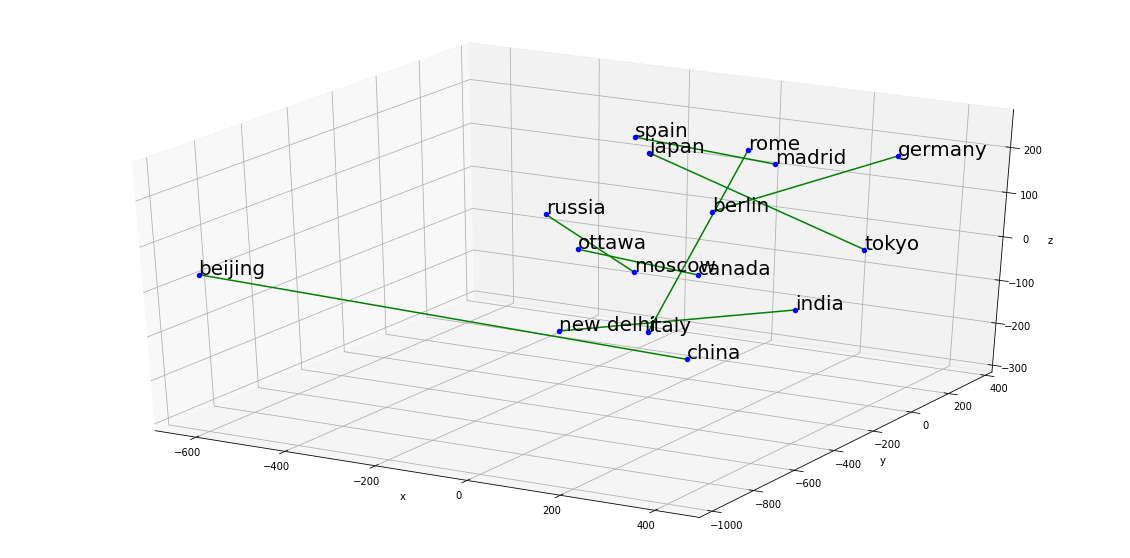

In [ ]:
fig = plt.figure(figsize=(20, 10))
ax = plt.axes(projection='3d')

for concap_idx, concap_val in enumerate(sample_concap_arr):
  country_nm_val = concap_val['CountryName']['val']
  country_nm_idx = viz_data_arr[country_nm_val]
  label_1 = country_nm_val
  x_1, y_1, z_1 = viz_vec_arr_org_tsne[country_nm_idx, 0], viz_vec_arr_org_tsne[country_nm_idx, 1], viz_vec_arr_org_tsne[country_nm_idx, 2]
  ax.scatter(x_1, y_1, z_1, color='b')
  ax.text(x_1, y_1, z_1, '%s' % (label_1), size=20, zorder=3, color='k')

  capital_nm_val = concap_val['CapitalName']['val']
  capital_nm_idx = viz_data_arr[capital_nm_val]
  label_2 = capital_nm_val
  x_2, y_2, z_2 = viz_vec_arr_org_tsne[capital_nm_idx, 0], viz_vec_arr_org_tsne[capital_nm_idx, 1], viz_vec_arr_org_tsne[capital_nm_idx, 2]
  ax.scatter(x_2, y_2, z_2, color='b')
  ax.text(x_2, y_2, z_2, '%s' % (label_2), size=20, zorder=3, color='k')

  # continent_nm_val = concap_val['ContinentName']['val']
  # continent_nm_idx = viz_data_arr[continent_nm_val]
  # label_3 = continent_nm_val
  # x_3, y_3, z_3 = viz_vec_arr_org_tsne[continent_nm_idx, 0], viz_vec_arr_org_tsne[continent_nm_idx, 1], viz_vec_arr_org_tsne[continent_nm_idx, 2]
  # ax.scatter(x_3, y_3, z_3, color='b')
  # ax.text(x_3, y_3, z_3, '%s' % (label_2), size=20, zorder=3, color='k')

  # ax.plot([x_1,x_2,x_3],[y_1,y_2,y_3],[z_1,z_2,z_3],color = 'g')
  ax.plot([x_1,x_2],[y_1,y_2],[z_1,z_2],color = 'g')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

# def animate(frame):
#   ax.view_init(30, frame/4)
#   plt.pause(.001)
#   return fig

# # anim = animation.FuncAnimation(fig, animate, frames=200, interval=50)
# # HTML(anim.to_html5_video())

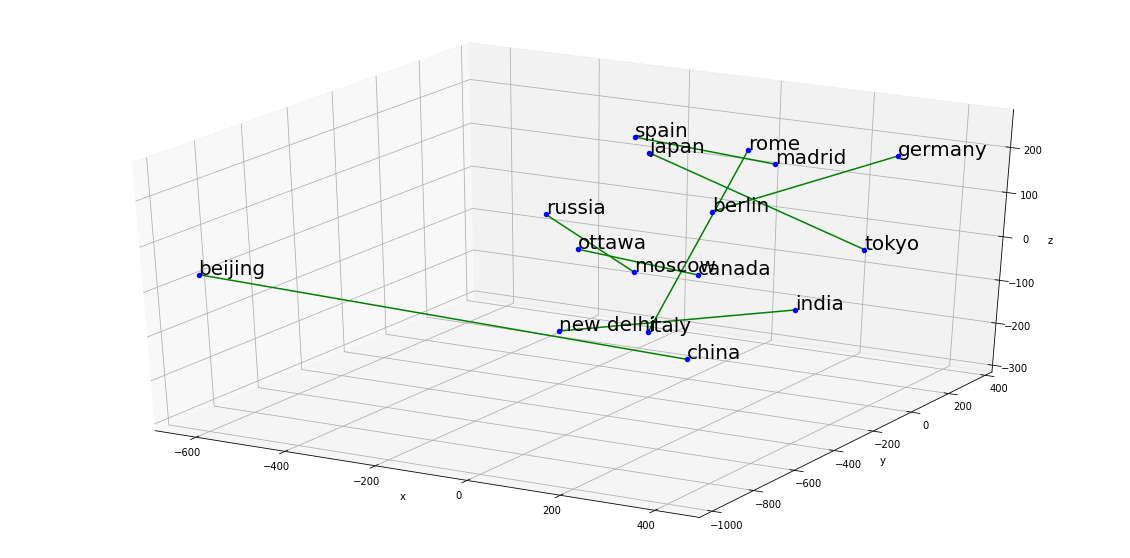

In [ ]:
fig = plt.figure(figsize=(20, 10))
ax = plt.axes(projection='3d')

for concap_idx, concap_val in enumerate(sample_concap_arr):
  country_nm_val = concap_val['CountryName']['val']
  country_nm_idx = viz_data_arr[country_nm_val]
  label_1 = country_nm_val
  x_1, y_1, z_1 = viz_vec_arr_enc_tsne[country_nm_idx, 0], viz_vec_arr_enc_tsne[country_nm_idx, 1], viz_vec_arr_enc_tsne[country_nm_idx, 2]
  ax.scatter(x_1, y_1, z_1, color='b')
  ax.text(x_1, y_1, z_1, '%s' % (label_1), size=20, zorder=3, color='k')

  capital_nm_val = concap_val['CapitalName']['val']
  capital_nm_idx = viz_data_arr[capital_nm_val]
  label_2 = capital_nm_val
  x_2, y_2, z_2 = viz_vec_arr_enc_tsne[capital_nm_idx, 0], viz_vec_arr_enc_tsne[capital_nm_idx, 1], viz_vec_arr_enc_tsne[capital_nm_idx, 2]
  ax.scatter(x_2, y_2, z_2, color='b')
  ax.text(x_2, y_2, z_2, '%s' % (label_2), size=20, zorder=3, color='k')

  # continent_nm_val = concap_val['ContinentName']['val']
  # continent_nm_idx = viz_data_arr[continent_nm_val]
  # label_3 = continent_nm_val
  # x_3, y_3, z_3 = viz_vec_arr_enc_tsne[continent_nm_idx, 0], viz_vec_arr_enc_tsne[continent_nm_idx, 1], viz_vec_arr_enc_tsne[continent_nm_idx, 2]
  # ax.scatter(x_3, y_3, z_3, color='b')
  # ax.text(x_3, y_3, z_3, '%s' % (label_2), size=20, zorder=3, color='k')

  # ax.plot([x_1,x_2,x_3],[y_1,y_2,y_3],[z_1,z_2,z_3],color = 'g')
  ax.plot([x_1,x_2],[y_1,y_2],[z_1,z_2],color = 'g')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

# def animate(frame):
#   ax.view_init(30, frame/4)
#   plt.pause(.001)
#   return fig

# # anim = animation.FuncAnimation(fig, animate, frames=200, interval=50)
# # HTML(anim.to_html5_video())

# Resources 

### Papers


### Blogs
1) https://towardsdatascience.com/custom-datasets-in-pytorch-part-2-text-machine-translation-71c41a3e994e <br>
2) https://gmihaila.medium.com/better-batches-with-pytorchtext-bucketiterator-12804a545e2a <br>
3) https://medium.com/pytorch/implementing-an-autoencoder-in-pytorch-19baa22647d1 <br>

### Videos
### Lectures/notes